In [44]:
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import numpy as np

g = 9.81
pi = math.pi





In [37]:
class Save_temp_fluid_c(object):
    """
    Класс для сохранения значений температуры внутри функции
    temp_fluid, в которой решения выполняются итеративно
    с помощью fsolve()
    """

    def __init__(self, init):
        """
        Начальное значение температуры
        """
        self.temp_fluid_c = init

    def save(self, value):
        """
        Сохранение вычисленных значений T в класс
        """
        self.temp_fluid_c = value


class system_properties(object):
    """
    Класс для задания всех необходимых свойств для расчета КРТ
    """
    def __init__(self):
        # convective heat transfer in an Oil Well
        self.ql_m3sec = 79.5 / 86400
        self.qg_m3sec = 283 / 86400
        self.kl_wmc = 0.138
        self.kg_wmc = 1.73 * 10 ** (-4)
        self.rhol_kgm3 = 882.9
        self.rhog_kgm3 = 80.3
        self.cpl_jkgc = 2512
        self.cpg_jkgc = 2093
        self.mul_pas = 0.015
        self.mug_pas = 1.5 * 10 ** (-4)
        self.rti_m = 0.0259

        # natural convection in well annulus
        self.rto_m = 0.0561
        self.rci_m = 0.0797
        # parametres are medium
        self.mu_an_pas = 0.0001
        self.cp_an_jkgc = 1004.81
        self.rho_an_kgm3 = 36.92
        self.k_an_wmc = 0.865
        self.betta_1c = 0.004824
        self.delta_temp_an_c = 3

        # overall heat transfer coefficient
        self.rco_m = 0.0889
        self.rwb_m = 0.1079
        self.kcem_wmc = 0.779
        self.kt_wmc = 25
        self.ke_wmc = 2.422

        self.time_sec = 100 * 7 * 24 * 3600
        self.rhoe_kgm3 = 2504
        self.cpe_jkgc = 1256

        self.tei_c = 93.3
        self.distance_m = 1000
        self.gg_cm = 0.027
        self.gamma_gas = 0.65
        self.gamma_api = 29

        self.p_pa = 792.9 * 10 ** 3

        #переменные, необходимые для реализации примеров
        '''self.pwh = 115
        self.mt_kgs = 1.07
        self.rp_sm3sm3 = 3.56'''
        
        #переменные для русской методики
        self.tetta_c = 11  # температура нейтрального слоя земли
        self.h_pump_m = 400 # высота подвеса насоса над забоем
        self.efficency_motor_perc = 70
        self.efficency_pump_perc = 40
        self.power_pump_v = 81 * 10**3
        self.lenth_motor_m = 15 


def_prop = system_properties()  # создание класса стандартный свойств


def q_motor_v(a_motor, d_motor_m, l_motor_m, t_wall_motor_c, tf_c):
    """
    Тепловой поток, выделяемый электродвигателем, передаваемый теплоотдачей обтекаемой скважинной продукции
    :param a_motor: коэффициент теплоотдачи от поверхности стенки э/д,
    :param d_motor_m: диаметр э/д, м
    :param l_motor_m: длина э/д, м
    :param t_wall_motor_c: температура стенок э/д, С
    :param tf_c: температура скважинной продукции, С
    :return: тепловой поток, Ватт
    """
    return a_motor * pi * d_motor_m * l_motor_m * (t_wall_motor_c - tf_c)


def t_wall_motor_c(tf_c, n_motor_v, efficiency_perc, a_motor, d_motor_m, l_motor_m):
    efficiency = efficiency_perc / 100
    return tf_c + n_motor_v * (1 - efficiency) / a_motor / pi / d_motor_m / l_motor_m


def de_m(dwb_m, ae_m2c, time_sec):
    """
    Диаметр окружающей ГП, соответствующей естесственной температуры
    :param dwb_m: диаметр скважины (цементного кольца), м
    :param ae_m2c: коэффициент температуропроводности ГП, м2 / сек
    :param time_sec: время прогрева, сек
    :return: диаметр возмущенной зоны, м
    """
    return dwb_m + 4 * math.sqrt(ae_m2c + time_sec)


def a_complex(dti_m, k_vm3c, gf_kgsec, cpf_jkgc):
    """
    Размерный комплекс А, учитывающий особенности теплообмена
    :param dti_m: внутренний диаметр трубы, где поднимается флюид, м ???
    :param k_vm3c: коэффициент теплопередачи от добываемого флюида в ГП, Ватт / м2 / С
    :param gf_kgsec: массовый расход флюида, кг / сек
    :param cpf_jkgc: теплоемкость флюида, Дж / кг / С
    :return: А, 1/м
    """
    return pi * dti_m * k_vm3c / gf_kgsec / cpf_jkgc


def m_complex(ql_vm, gf_kgsec, cpf_jkgc):
    """
    Размерный комплекс м, учитывающий особенности теплообмена
    :param ql_vm: линейная плотность внутренних источников (+) и стоков (-) теплоты, Вт / м
    :param gf_kgsec: массовый расход флюида, кг / сек
    :param cpf_jkgc: теплоемкость флюида, Дж / кг / С
    :return: m, К / м
    """
    return ql_vm / gf_kgsec / cpf_jkgc


def tf_along_pump(x, t1_c, tetta, gg_cm, a_pump_1m, h_pump_m, m_km):
    first_part = gg_cm / a_pump_1m * ( - np.exp(-a_pump_1m * x) + 1) + tetta 
    second_part = (t1_c - tetta) * np.exp(-a_pump_1m * x) 
    third_part =  - gg_cm * (h_pump_m * (np.exp(-a_pump_1m * x) - 1)  + x) 
    fourth_part = m_km / a_pump_1m * (1 - np.exp(-a_pump_1m * x))
    return first_part + second_part + third_part + fourth_part
    
    

In [38]:
x = np.arange(1, 15, 1)
all_prop = system_properties()

In [39]:
print(-np.exp(x))

[-2.71828183e+00 -7.38905610e+00 -2.00855369e+01 -5.45981500e+01
 -1.48413159e+02 -4.03428793e+02 -1.09663316e+03 -2.98095799e+03
 -8.10308393e+03 -2.20264658e+04 -5.98741417e+04 -1.62754791e+05
 -4.42413392e+05 -1.20260428e+06]


In [40]:
var_k_vm3c = 1
var_ql_pump_vm = (all_prop.power_pump_v * all_prop.efficency_motor_perc * 
                  all_prop.efficency_pump_perc / 10000 / all_prop.lenth_motor_m)
var_gf_kgsec = all_prop.ql_m3sec * all_prop.rhol_kgm3

var_m_complex = m_complex(var_ql_pump_vm, var_gf_kgsec, all_prop.cpl_jkgc)

var_a_complex = a_complex(all_prop.rti_m *2, var_k_vm3c, var_gf_kgsec, all_prop.cpl_jkgc)

t1_c = 80 

distribution_tf_c = tf_along_pump(x, t1_c, all_prop.tetta_c, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)


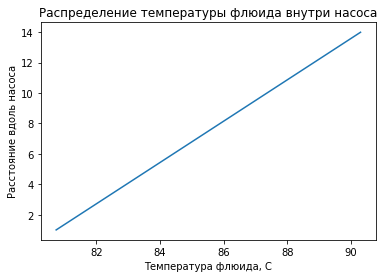

In [47]:

plt.plot(distribution_tf_c,x)
plt.title('Распределение температуры флюида внутри насоса')
plt.xlabel('Температура флюида, С')
plt.ylabel('Расстояние вдоль насоса')
plt.show()